##### This is a notebook to visualize the candidates that were found using Cappuccino. If running on very large batches (1000s of observations with hundreds of candidates), you can also impose some post-filtering of candidates 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import h5py
import hdf5plugin
from matplotlib import pyplot as plt, cm
from matplotlib import colors
from scipy.stats import pearsonr
import scipy
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

from skimage.transform import hough_line, hough_line_peaks
from tqdm import tqdm

##### Specify which database of candidates you are plotting

In [38]:
# if doing a large batch number:
batch = False
if batch == True:
    # specifiy the batch number you are running on
    number = 12
    csv_path = f'/datax/scratch/calebp/cappuccino_runs/all_batches_number_{number}_sig_10_pearsonthreshold_7_blocksize_2048_edge_50.csv'
if batch == False: 
    # specify that target database path you are running on
    csv_path = "/datax/scratch/calebp/cappuccino_runs/target_62207_date_57543_node_spliced_sig_10_pearsonthreshold_7_blocksize_2048_edge_50.csv"


table = pd.read_csv(csv_path)
print("# of flagged signals:",len(table))

all_file_names = table["All Files"]
all_file_names = [eval(i) for i in all_file_names]
indexes = table["Block Index"]


fch1 = float(table["Start Freq"][0])
foff = float(table["Bin Freq"][0])
targets = table["Target"]
block_size = int(csv_path.split(".")[-2].split("_")[-3])


loc = 0

file_ON = all_file_names[loc][0]
file_OFF = all_file_names[loc][1]
file3 = all_file_names[loc][2]
file4 = all_file_names[loc][3]
file5 = all_file_names[loc][4]
file6 = all_file_names[loc][5]


hf_ON = h5py.File(file_ON, 'r')
hf_OFF = h5py.File(file_OFF, 'r')
hf_ON2 = h5py.File(file3, 'r')
hf_OFF2 = h5py.File(file4, 'r')
hf_ON3 = h5py.File(file5, 'r')
hf_OFF3 = h5py.File(file6, 'r')

# of flagged signals: 97


In [23]:
xs = np.zeros((16,16))

In [40]:
def plot_candidates_sparse(hf1,hf2,hf3,hf4,hf5,hf6,lower,upper,file_ON,foff,fch1):
    obs1 = np.squeeze(hf1['data'][:,:,lower:upper],axis=1)
    obs2 = np.squeeze(hf2['data'][:,:,lower:upper],axis=1)
    obs3 = np.squeeze(hf3['data'][:,:,lower:upper],axis=1)
    obs4 = np.squeeze(hf4['data'][:,:,lower:upper],axis=1)
    obs5 = np.squeeze(hf5['data'][:,:,lower:upper],axis=1)
    obs6 = np.squeeze(hf6['data'][:,:,lower:upper],axis=1)


    cadence_max = np.max([np.max(obs1),np.max(obs2),np.max(obs3),np.max(obs4),np.max(obs5),np.max(obs6)])
    
    obs1_values = (obs1/cadence_max).flatten()
    obs2_values = (obs2/cadence_max).flatten()
    obs3_values = (obs3/cadence_max).flatten()
    obs4_values = (obs4/cadence_max).flatten()
    obs5_values = (obs5/cadence_max).flatten()
    obs6_values = (obs6/cadence_max).flatten()
    obs1 = obs1/np.max(obs1)
    obs2 = obs2/np.max(obs2)
    obs3 = obs3/np.max(obs3)
    obs4 = obs4/np.max(obs4)
    obs5 = obs5/np.max(obs5)
    obs6 = obs6/np.max(obs6)



    full_cadence = np.squeeze([np.concatenate((obs1,obs2,obs3,obs4,obs5,obs6))])


    # plot the waterfall
    fig, axs = plt.subplots(6,figsize=(5, 7))
    axs[0].imshow(obs1,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[1].imshow(obs2,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[2].imshow(obs3,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[3].imshow(obs4,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[4].imshow(obs5,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[5].imshow(obs6,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    plt.subplots_adjust(hspace=0)
    center_freq = fch1+foff*(lower)    
    name = file_ON.split('/')[-1]

    target = name.split("_")[-2]
    obs_num = name.split("_")[-1]
    MJD = name.split("_")[3]
    node = name.split("_")[0]

    axs[0].tick_params(axis='y', labelsize=12)
    axs[1].tick_params(axis='y', labelsize=12)
    axs[2].tick_params(axis='y', labelsize=12)
    axs[3].tick_params(axis='y', labelsize=12)
    axs[4].tick_params(axis='y', labelsize=12)
    axs[5].tick_params(axis='y', labelsize=12)

    axs[0].set_ylabel("Time [s]",fontsize=12)
    axs[1].set_ylabel("Time [s]",fontsize=12)
    axs[2].set_ylabel("Time [s]",fontsize=12)
    axs[3].set_ylabel("Time [s]",fontsize=12)
    axs[4].set_ylabel("Time [s]",fontsize=12)
    axs[5].set_ylabel("Time [s]",fontsize=12)

    axs[0].set_title(f"Target: {target} -- MJD: {MJD} -- Node: {node}",fontsize=10)

    axs[5].tick_params(axis='x', labelsize=12)

    
    plt.xlabel(f"Rel. Freq. [kHz] from {np.round(center_freq,5)} Mhz",fontsize=15)
    # fig.supylabel("Time [s]",fontsize=15)
    plt.savefig(f"/datax/scratch/calebp/cappuccino_plots/target_HIP62207_date_57543_frequency_{np.round(center_freq,5)}.png")
    plt.show()

def filter_zero_drift(obs1,obs2,obs3,obs4,obs5,obs6,filtering_level):
    # checking if there are lots of zero drift signals in OFF observations, or ON and OFF observations
        
    # plot the integrated frequency
    obs1_int = obs1.sum(axis=0)
    obs2_int = obs2.sum(axis=0)
    obs3_int = obs3.sum(axis=0)
    obs4_int = obs4.sum(axis=0)
    obs5_int = obs5.sum(axis=0)
    obs6_int = obs6.sum(axis=0)

    obs_sums = [obs1_int,obs2_int,obs3_int,obs4_int,obs5_int,obs6_int]


    whole_sum = obs1_int+obs2_int+obs3_int+obs4_int+obs5_int+obs6_int
    off_sum = obs2_int+obs4_int+obs6_int


    if filtering_level < 3:
        whole_sum = off_sum

    all_peaks = []

    for i,obs_int in enumerate([whole_sum]):
        obs_data = obs_int/np.max(obs_int)
        sigma_mult = scipy.stats.median_abs_deviation(obs_data)
        peaks, properties = find_peaks(obs_data, prominence=10*sigma_mult, width=1,distance=300)
        all_peaks.append(len(peaks))

        freqs = np.arange(0,len(whole_sum),1)
        # plt.plot(freqs,whole_sum)
        # plt.scatter(freqs[peaks],whole_sum[peaks],color='orange',s=50)
        # plt.show()


    return all_peaks[-1]


def filter_more_broadband(obs1,obs2,obs3,obs4,obs5,obs6):
    # plot the integrated frequency
    obs1_int = (obs1.sum(axis=1)/np.max(obs1.sum(axis=1))).tolist()
    obs2_int = (obs2.sum(axis=1)/np.max(obs2.sum(axis=1))).tolist()
    obs3_int = (obs3.sum(axis=1)/np.max(obs3.sum(axis=1))).tolist()
    obs4_int = (obs4.sum(axis=1)/np.max(obs4.sum(axis=1))).tolist()
    obs5_int = (obs5.sum(axis=1)/np.max(obs5.sum(axis=1))).tolist()
    obs6_int = (obs6.sum(axis=1)/np.max(obs6.sum(axis=1))).tolist()

    whole_sum = obs1_int+obs2_int+obs3_int+obs4_int+obs5_int+obs6_int

    accums = []

    for obs in [obs1,obs2,obs3,obs4,obs5,obs6]:
        all_points = np.zeros((16,16))
        xs = []
        ys = []
        for time_bin in range(16):
            obs_data = (obs[time_bin])/np.max(obs[time_bin])
            # obs_data = (obs[2*time_bin]+obs[2*time_bin+1])/np.max(obs[2*time_bin]+obs[2*time_bin+1])
            sigma_mult = scipy.stats.median_abs_deviation(obs_data)
            peaks, properties = find_peaks(obs_data, prominence=10*sigma_mult, width=1)
            for peak in peaks:
                ys.append(time_bin)
                xs.append(peak)

        if len(xs) > 0:
            # print(xs)
            xs = 15*np.array(xs)/np.max(xs)
            ys = 15*np.array(ys)/np.max(ys)

            xs = [int(np.floor(x)) for x in xs]
            ys = [int(np.floor(y)) for y in ys]
            
            for i in range(0,len(ys)):
                all_points[xs[i]][ys[i]] = 1
                
            tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
            h, theta, d = hough_line(all_points, theta=tested_angles)
            aaccums, angle, dist = hough_line_peaks(h, theta, d)
            accums.append(np.array(aaccums)[0])
        else:
            accums.append(0)
        
    num_pass = 0 

    # require three of the ons to have some sort of line present (at least 6 points)
    for i in [accums[0],accums[2],accums[4]]:
        if i>6:
            num_pass +=1

    if num_pass > 1:
        return True

    return False

def plot_candidates_info(hf1,hf2,hf3,hf4,hf5,hf6,lower,upper,file_ON,foff,fch1,filtering_level):
    obs1 = np.squeeze(hf1['data'][:,:,lower:upper],axis=1)
    obs2 = np.squeeze(hf2['data'][:,:,lower:upper],axis=1)
    obs3 = np.squeeze(hf3['data'][:,:,lower:upper],axis=1)
    obs4 = np.squeeze(hf4['data'][:,:,lower:upper],axis=1)
    obs5 = np.squeeze(hf5['data'][:,:,lower:upper],axis=1)
    obs6 = np.squeeze(hf6['data'][:,:,lower:upper],axis=1)

    # check for zero drift:

    if filtering_level > 0:
        zero_drift_num = filter_zero_drift(obs1,obs2,obs3,obs4,obs5,obs6,filtering_level)
        if zero_drift_num >=3:
            print("High RFI")
            # return 

    if filtering_level > 1:
        try:
            clear_signal = filter_more_broadband(obs1,obs2,obs3,obs4,obs5,obs6)
            if  clear_signal== False:
                print("No clear signals")
                return
        except:
            return
    
    
    cadence_max = np.max([np.max(obs1),np.max(obs2),np.max(obs3),np.max(obs4),np.max(obs5),np.max(obs6)])
    
    obs1_values = (obs1/cadence_max).flatten()
    obs2_values = (obs2/cadence_max).flatten()
    obs3_values = (obs3/cadence_max).flatten()
    obs4_values = (obs4/cadence_max).flatten()
    obs5_values = (obs5/cadence_max).flatten()
    obs6_values = (obs6/cadence_max).flatten()
    obs1 = obs1/np.max(obs1)
    obs2 = obs2/np.max(obs2)
    obs3 = obs3/np.max(obs3)
    obs4 = obs4/np.max(obs4)
    obs5 = obs5/np.max(obs5)
    obs6 = obs6/np.max(obs6)

    k1 = scipy.stats.kurtosis(obs1_values)
    k2 = scipy.stats.kurtosis(obs2_values)
    k3 = scipy.stats.kurtosis(obs3_values)
    k4 = scipy.stats.kurtosis(obs4_values)
    k5 = scipy.stats.kurtosis(obs5_values)
    k6 = scipy.stats.kurtosis(obs6_values)

    



    full_cadence = np.squeeze([np.concatenate((obs1,obs2,obs3,obs4,obs5,obs6))])


    # plot the waterfall
    fig, axs = plt.subplots(6,figsize=(5, 7))
    axs[0].imshow(obs1,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[1].imshow(obs2,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[2].imshow(obs3,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[3].imshow(obs4,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[4].imshow(obs5,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[5].imshow(obs6,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    plt.subplots_adjust(hspace=0)
    center_freq = fch1+foff*(lower)    
    name = file_ON.split('/')[-1]

    target = name.split("_")[-2]
    obs_num = name.split("_")[-1]
    MJD = name.split("_")[3]
    node = name.split("_")[0]

    axs[0].tick_params(axis='y', labelsize=12)
    axs[1].tick_params(axis='y', labelsize=12)
    axs[2].tick_params(axis='y', labelsize=12)
    axs[3].tick_params(axis='y', labelsize=12)
    axs[4].tick_params(axis='y', labelsize=12)
    axs[5].tick_params(axis='y', labelsize=12)

    axs[0].set_ylabel("Time [s]",fontsize=12)
    axs[1].set_ylabel("Time [s]",fontsize=12)
    axs[2].set_ylabel("Time [s]",fontsize=12)
    axs[3].set_ylabel("Time [s]",fontsize=12)
    axs[4].set_ylabel("Time [s]",fontsize=12)
    axs[5].set_ylabel("Time [s]",fontsize=12)

    axs[0].set_title(f"Target: {target} -- MJD: {MJD} -- Node: {node}",fontsize=10)

    axs[5].tick_params(axis='x', labelsize=12)

    
    plt.xlabel(f"Rel. Freq. [kHz] from {np.round(center_freq,5)} Mhz",fontsize=15)
    # fig.supylabel("Time [s]",fontsize=15)
    plt.savefig(f"/datax/scratch/calebp/cappuccino_plots/target_HIP62207_date_57543_frequency_{np.round(center_freq,5)}.png")
    plt.show()


    
    if False:
        for i in range(0,6):
            obs_data = obs_sums[i]/np.max(obs_sums[i])
            lower_quantile = np.quantile(obs_data,.85)
            lower_slice = obs_data[obs_data < lower_quantile]
            sigma_mult = np.std(lower_slice)
            peaks, properties = find_peaks(obs_data, prominence=10*sigma_mult, width=1)
            plt.plot(peaks,obs_data[peaks],"x",color='orange')
            plt.plot(obs_data)
            plt.title(f"Obs {i+1}")
            plt.show()
        plt.plot(peaks,obs_data[peaks],"x",color='orange')
        plt.plot(whole_sum/np.max(whole_sum))
        plt.title("Full cadence")
        plt.show()




  0%|          | 0/10 [00:00<?, ?it/s]

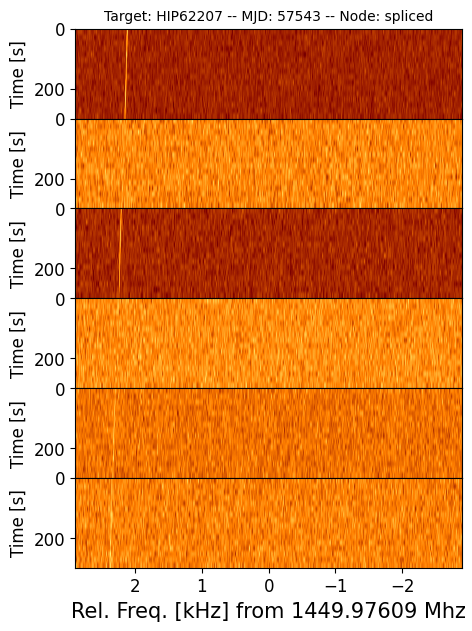

 10%|█         | 1/10 [00:01<00:14,  1.58s/it]

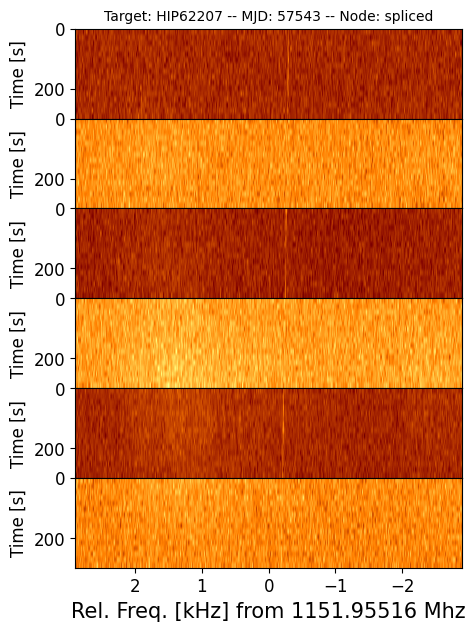

 20%|██        | 2/10 [00:03<00:12,  1.58s/it]

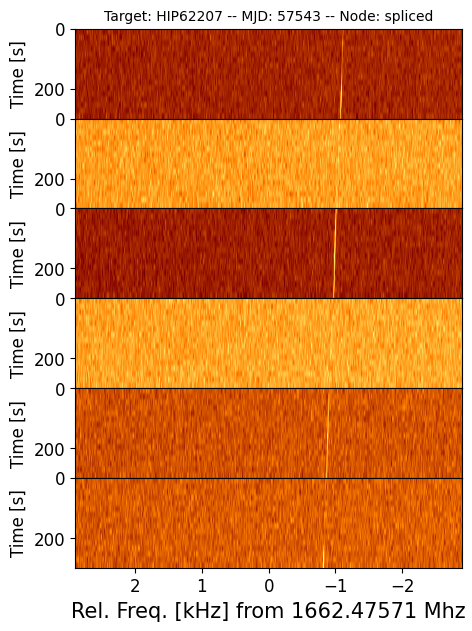

 30%|███       | 3/10 [00:04<00:10,  1.54s/it]

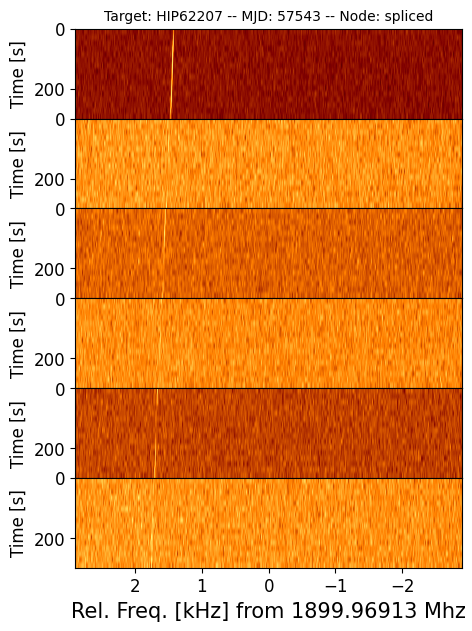

 40%|████      | 4/10 [00:06<00:09,  1.52s/it]

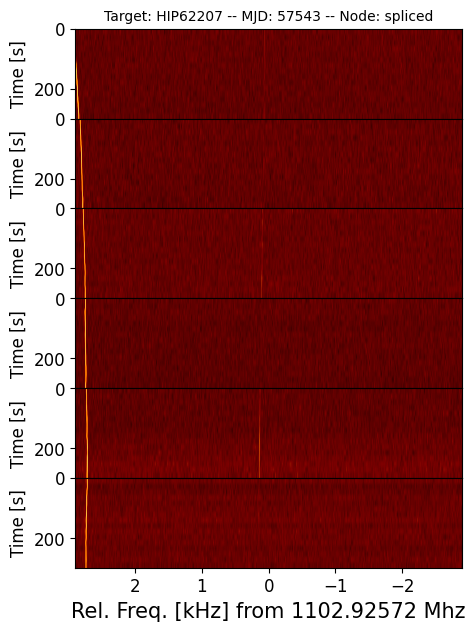

 50%|█████     | 5/10 [00:07<00:07,  1.53s/it]

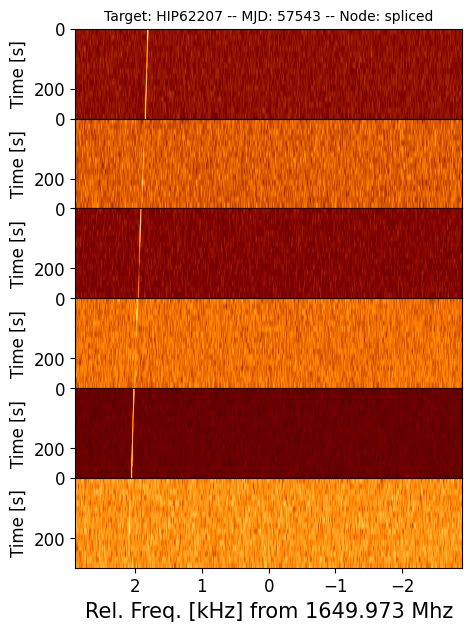

 60%|██████    | 6/10 [00:09<00:06,  1.52s/it]

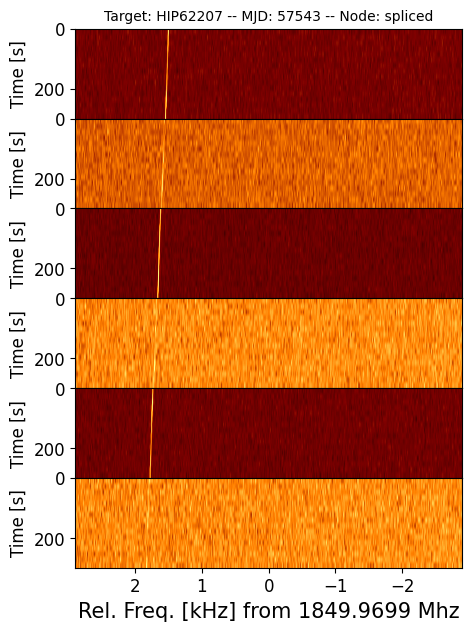

 70%|███████   | 7/10 [00:10<00:04,  1.61s/it]

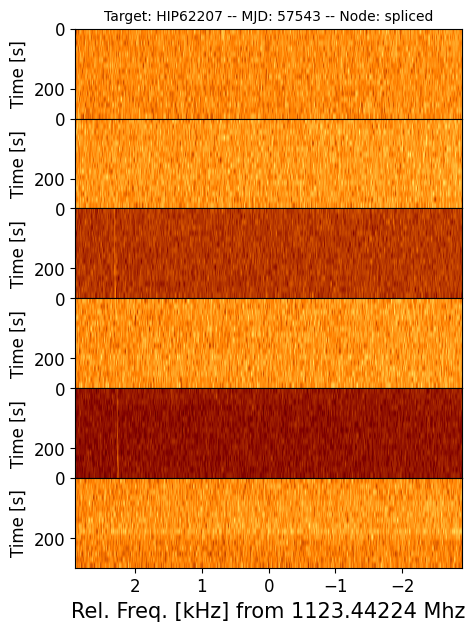

 80%|████████  | 8/10 [00:12<00:03,  1.58s/it]

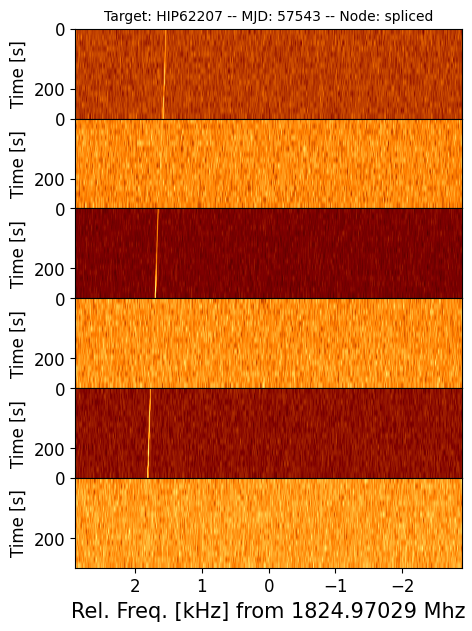

 90%|█████████ | 9/10 [00:14<00:01,  1.57s/it]

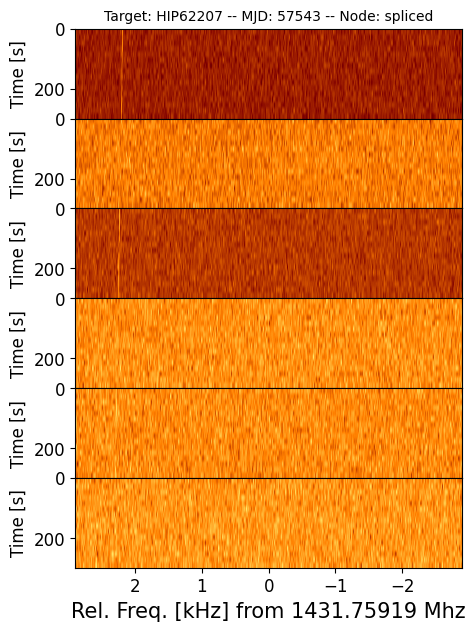

100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


In [42]:
old_target = "none"

# set filtering level: 1--> removes candidates in high RFI environments based on OFF observations,2--> removes candidates with weak signals (by performing a Hough transform), 3 --> removes candidates in high RFI environments based on all observations
filtering_level= 3
for num in tqdm(range(0,10)):
    i = indexes[num]
    target = targets[num]
    if target != old_target:        
        file_ON = all_file_names[num][0]
        file_OFF = all_file_names[num][1]
        file3 = all_file_names[num][2]
        file4 = all_file_names[num][3]
        file5 = all_file_names[num][4]
        file6 = all_file_names[num][5]
        
        
        hf_ON = h5py.File(file_ON, 'r')
        hf_OFF = h5py.File(file_OFF, 'r')
        hf_ON2 = h5py.File(file3, 'r')
        hf_OFF2 = h5py.File(file4, 'r')
        hf_ON3 = h5py.File(file5, 'r')
        hf_OFF3 = h5py.File(file6, 'r')
        
        fch1 = float(table["Start Freq"][num])
        foff = float(table["Bin Freq"][num])

    old_target = target

    
    
    lower = (i) * block_size
    upper = (i+1) * block_size
    lower = int(lower)
    upper = int(upper)
    plot_candidates_info(hf_ON,hf_OFF,hf_ON2,hf_OFF2,hf_ON3,hf_OFF3,lower,upper,file_ON,foff,fch1,filtering_level)
